# Lab 5: time series forecast with AutoGluon

[AutoGluon](https://auto.gluon.ai/stable/index.html) is an open-source AutoML library that automates machine learning and deep learning for applications involving image, text, and tabular data. It enables users to quickly develop high-performance models with just a few lines of code by automating tasks like data preprocessing, model selection, hyperparameter tuning, and ensemble learning.

[AutoGluon Time Series](https://auto.gluon.ai/stable/tutorials/timeseries/index.html) can forecast the future values of multiple time series given the historical data and other related covariates. A single call to AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html)’s `fit()` method trains multiple models to generate accurate probabilistic forecasts, and does not require you to manually deal with cumbersome issues like model selection and hyperparameter tuning.

Under the hood, AutoGluon combines various state of the art forecasting algorithms. These include established statical methods like ETS and ARIMA from [`StatsForecast`](https://github.com/Nixtla/statsforecast), efficient tree-based forecasters like LightGBM based on [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular/index.html), flexible deep learning models like [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) and Temporal Fusion Transformer from [GluonTS](https://ts.gluon.ai/), and a pretrained zero-shot forecasting model, [Chronos](https://github.com/amazon-science/chronos-forecasting). 

This workshop features DeepAR algorithm in the notebook [lab 3](./lab3_sagemaker_deepar.ipynb) and Chronos in the notebook [lab 4](./lab4_chronos.ipynb).

AutoGluon Time Series provides a robust and easy way to use Chronos through the `TimeSeriesPredictor` API. More specifically:
- Chronos can be combined with other forecasting models to build accurate ensembles using the `high_quality` and `best_quality` presets.
- Alternatively, Chronos can be used as a standalone zero-shot model with presets such as `"chronos_small"` or `"chronos_base"`.

For the full list of available time series algorithm used in AutoGluon refer to the [Model Zoo](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html) page in the AutoGluon documentation.

This notebook demonstrate how to build time series forecast using AutoGluon Time Series API.

If you're not familiar with time series forecast, refer to [Forecasting Time Series in Depth](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html) section in the AutoGluon documentation for more details and background.

## Import packages

In [1]:
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
%pip install -q fsspec

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -Uq autogluon pip sagemaker s3fs

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.20.0 requires faiss-cpu<=1.8.0, which is not installed.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.
langchain-aws 0.1.16 requires boto3<1.35.0,>=1.34.131, but you have boto3 1.35.23 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# downgrade sentencepiece to 0.1.99 because it causes incompatibility issues in SMD 2.0
# this is going to be fixed in the next release of SMD
%pip install sentencepiece==0.1.99

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.2.0
    Uninstalling sentencepiece-0.2.0:
      Successfully uninstalled sentencepiece-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Uncomment if you need to restart kernel to get the packages
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [5]:
%matplotlib inline

import json
import os
import boto3
import zipfile
from time import gmtime, strftime, sleep
import datetime
import sagemaker
import numpy as np
import pandas as pd
import tqdm
import torch
import autogluon
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker, SelectMultiple, Select
)

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [6]:
from importlib.metadata import version
print(version('autogluon'))

1.1.1


## Set literals and general variables

In [7]:
# get domain_id and user profile name
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        domain_id = json.loads(f.read()).get('DomainId')
        print(f"SageMaker domain id: {domain_id}")

SageMaker domain id: d-mv9ybtbztu4a


In [8]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [9]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "autogluon-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "autogluon"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [10]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [11]:
os.makedirs("./data", exist_ok=True)

In [12]:
dataset_zip_file_name = 'LD2011_2014.txt.zip'
dataset_path = './data/LD2011_2014.txt'

s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [13]:
if not os.path.isfile(dataset_path):
    print(f'Downloading and unzipping the dataset to {dataset_path}')
    s3_client = boto3.client("s3")
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
    )

    zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
    zip_ref.extractall("./data")
    zip_ref.close()
    dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])
else:
    print(f'The dataset {dataset_path} exists, skipping download and unzip!')

The dataset ./data/LD2011_2014.txt exists, skipping download and unzip!


In [14]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [15]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [16]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [17]:
# resample to 2h intervals
freq = "2h"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1741.77it/s]


In [18]:
data_kw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,2.379442,28.538407,1.954822,160.569106,67.225610,260.416667,7.560769,352.693603,75.830420,53.897849,...,439.864383,40675.0,2816.983122,3980.113636,127.933507,7.753072,504.938543,118.948247,703.445748,12033.783784
2014-12-31 18:00:00,2.220812,28.449502,2.172024,208.587398,91.310976,385.788690,12.719050,359.427609,95.498252,84.408602,...,425.053533,43300.0,2793.776371,3454.545455,105.606258,5.266238,500.877963,47.787980,706.011730,9554.054054
2014-12-31 20:00:00,2.379442,24.004267,1.737619,174.288618,89.176829,330.357143,11.447145,292.508418,84.134615,75.806452,...,330.389008,39137.5,1676.160338,1857.954545,74.967405,4.169105,420.654083,131.886477,675.219941,8344.594595
2014-12-31 22:00:00,2.062183,21.692745,1.737619,161.331301,85.365854,311.383929,11.023177,251.262626,68.181818,72.446237,...,289.079229,31775.0,1591.244726,1303.977273,46.284224,7.533645,665.605795,178.422371,669.263196,7263.513514


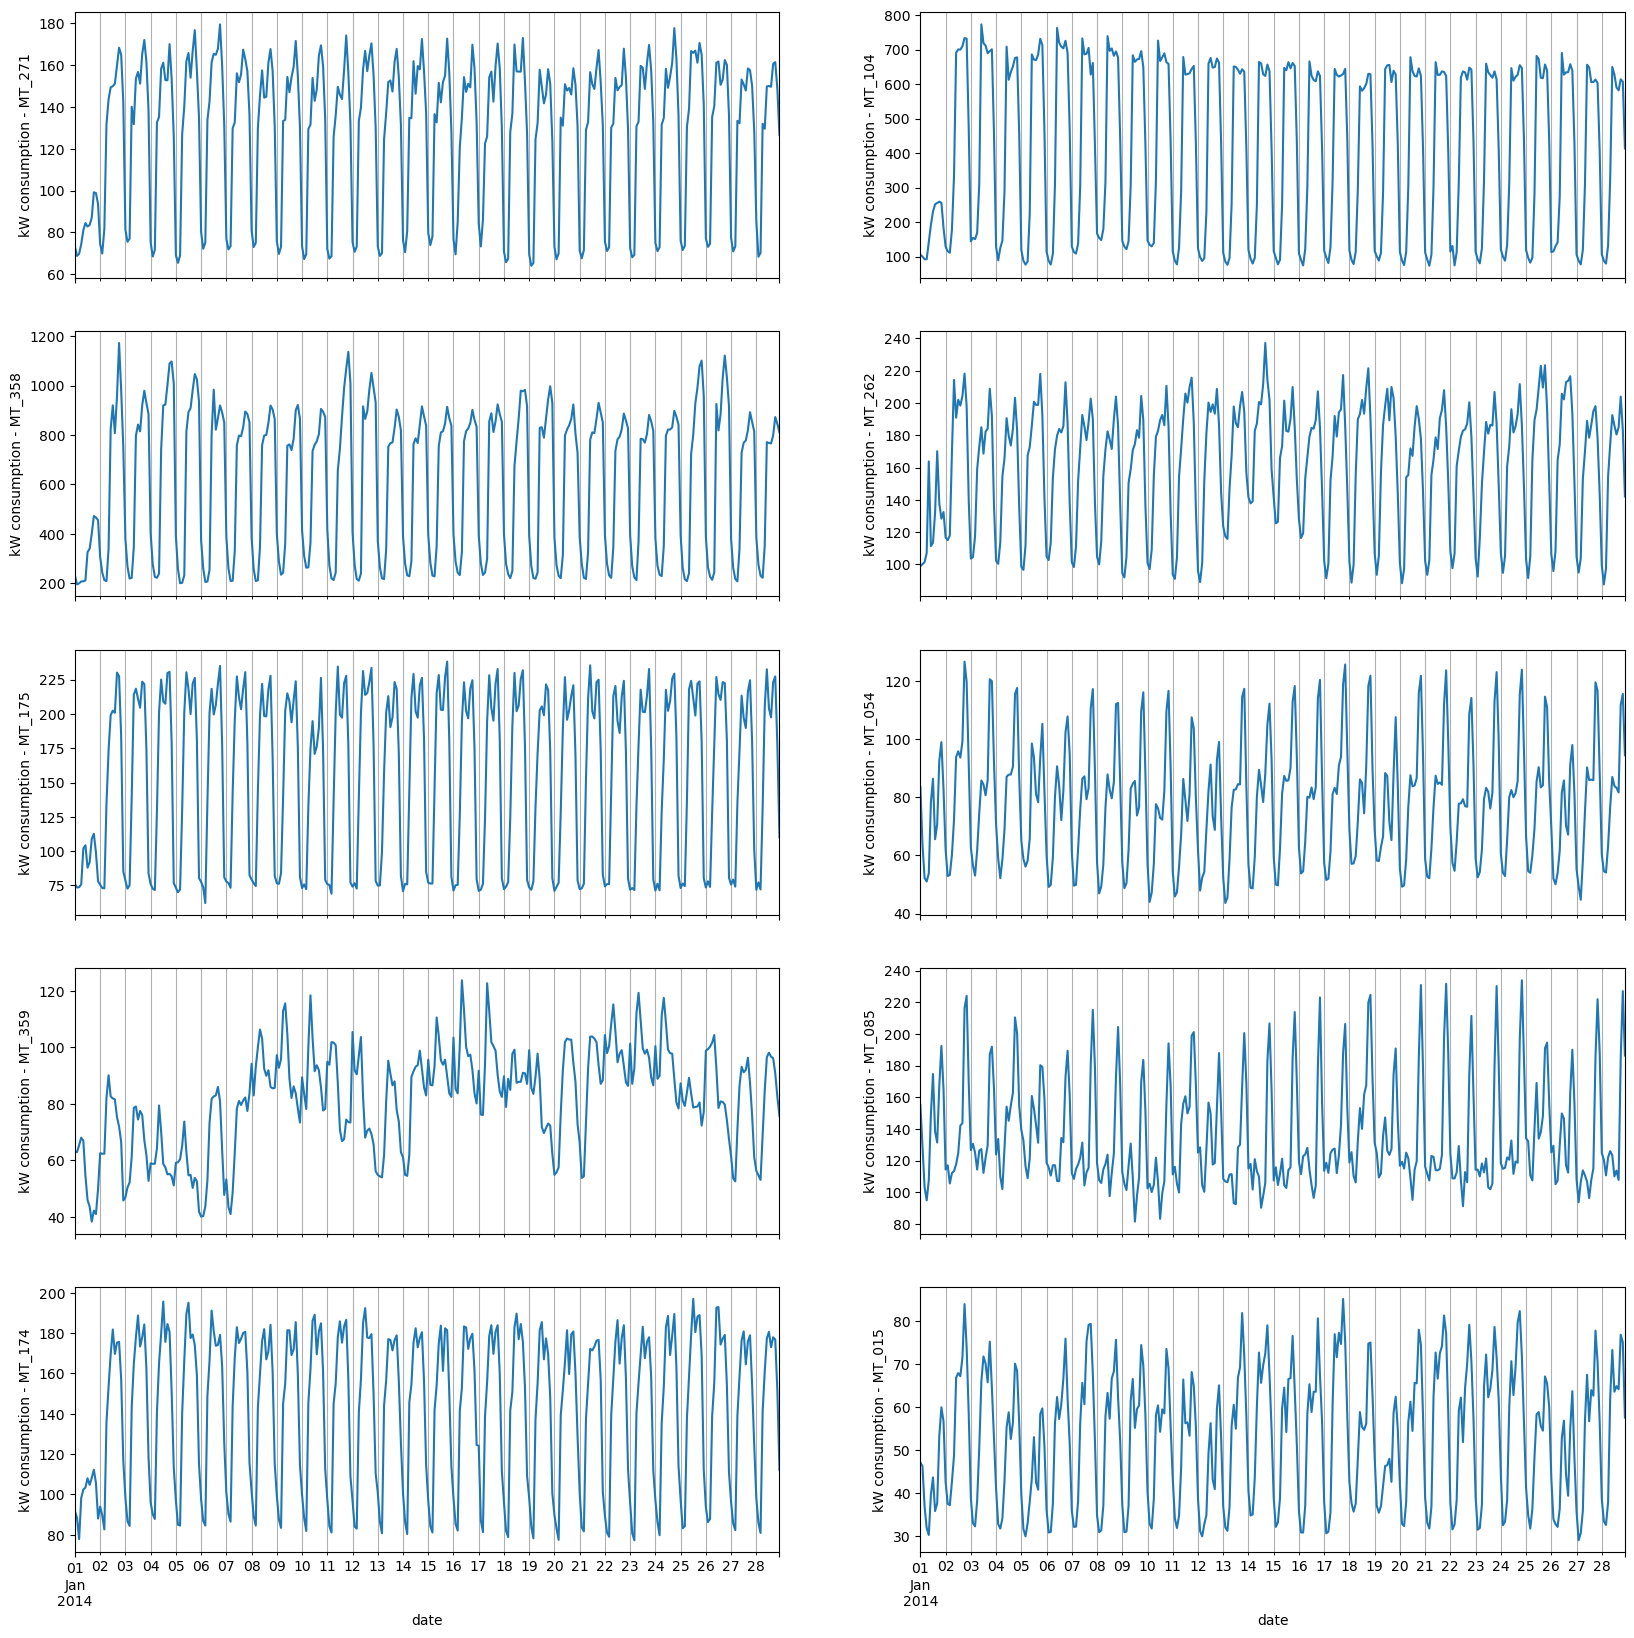

In [19]:
# show random timeseries for 28 day period
sample_size = 10
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts in enumerate(random.sample(timeseries, sample_size)):
    ts.loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts.name}")
    axx[i].grid(which="minor", axis="x")

Create a smaller dataset with a subset of time series:

In [20]:
# select two random time series to include in a small dataset
sample_size = 2
columns_to_keep = np.random.choice(data_kw.columns.to_list(), size=sample_size, replace=False)
columns_to_keep

array(['MT_330', 'MT_357'], dtype='<U6')

In [21]:
data_kw_small = data_kw[columns_to_keep]
data_kw_small

,MT_330,MT_357
2011-01-01 00:00:00,39.446875,0.000000
2011-01-01 02:00:00,46.099219,0.000000
2011-01-01 04:00:00,44.222656,0.000000
2011-01-01 06:00:00,45.239844,0.000000
2011-01-01 08:00:00,48.602344,0.000000
...,...,...
2014-12-31 16:00:00,125.892969,2619.318182
2014-12-31 18:00:00,112.316406,1884.469697
2014-12-31 20:00:00,44.770312,921.401515
2014-12-31 22:00:00,38.749219,789.772727


## Train AutoGluon models

To start with AutoGluon you need:
1. Convert your time series dataset to a [`TimeSeriesDataFrame`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html)
2. Configure AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html)
3. Fit models

This section takes you through these steps so that you have a trained predictor.

Refere to the [AutoGluon Time Series - Forecasting Quick Start](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html) documentation for details on time series forecasting.

In [22]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day

print(f"Sampling frequency set to {freq}. Generate predictions for {prediction_length} intervals")

Sampling frequency set to 2h. Generate predictions for 84 intervals


### Convert dataset to AutoGluon format

AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format). Each row of the data frame contains a single observation (timestep) of a single time series represented by:
- unique ID of the time series – `item_id` – as int or str  
- timestamp of the observation – `timestamp` – as a `pandas.Timestamp` or compatible format
- numeric value of the time series – `target`

You can choose the names of the columns arbitrary, but need to specify the names when constructing a `TimeSeriesDataFrame` object.

<div class="alert alert-info">
To reduce the training time and inference time you can use a subset of time series instead of the full dataset with 370 time series.
</div>

For AWS-led workshop please choose a small dataset by leaving the `USE_FULL_DATASET` on it's default value `False`. The training time for the small dataset is about 5-12 minutes depending on the used JupyterLab App instance. The train time for the full dataset is about 40-70 minutes depending on the instance type. See the section **Train models** for more data points on training times on different SageMaker instances.

In [23]:
USE_FULL_DATASET = False

In [24]:
if torch.cuda.device_count() < 1 and USE_FULL_DATASET:
    print(f"\033[91mWARNING: You don't use GPU instance for the notebook. The inference time on CPU instance will be not practical.\033[0m")

In [25]:
if USE_FULL_DATASET:
    ts_wide_df = data_kw
else:
    ts_wide_df = data_kw_small

Use the [`TimeSeriesDataFrame`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) classs to convert a Pandas DataFrame to AutoGluon time series Data Frame.

In [26]:
# converts a Pandas.DataFrame to AutoGluon TimeSeriesDataFrame
# note the function hardcodes column names and work only with the dataset in this notebook
def get_ts_df(
    df,
) ->  TimeSeriesDataFrame: 
    # Convert to an AutoGluon TimeSeriesDataFrame
    return TimeSeriesDataFrame.from_data_frame(
        # Melt the DataFrame into the long format
        pd.melt(
            df.reset_index(),
            id_vars='index', 
            value_vars=df.columns, 
            var_name='item_id', 
            value_name='target'
        ).rename(columns={'index': 'timestamp'}), # Rename the 'index' column to 'timestamp'
        id_column="item_id",
        timestamp_column="timestamp",
    )

In [27]:
ts_df = get_ts_df(ts_wide_df)

In [28]:
ts_df

target
item_id timestamp                       
MT_330  2011-01-01 00:00:00    39.446875
        2011-01-01 02:00:00    46.099219
        2011-01-01 04:00:00    44.222656
        2011-01-01 06:00:00    45.239844
        2011-01-01 08:00:00    48.602344
...                                  ...
MT_357  2014-12-31 16:00:00  2619.318182
        2014-12-31 18:00:00  1884.469697
        2014-12-31 20:00:00   921.401515
        2014-12-31 22:00:00   789.772727
        2015-01-01 00:00:00    76.704545

[35066 rows x 1 columns]

AutoGluon generates forecasts for each time series individually, without modeling interactions between different items/time series. 

### Split the dataset to train and test
Split the dataset:
- In the `train_df`, the last `prediction_length` time steps are removed from the end of each time series - meaning each time series contains the slice `[:-prediction_length]`
- The `test_df` contains the same data as the original dataset

In [29]:
train_df, test_df = ts_df.train_test_split(prediction_length)

In [30]:
train_df.tail()

target
item_id timestamp                       
MT_357  2014-12-24 16:00:00  2689.393939
        2014-12-24 18:00:00  1911.931818
        2014-12-24 20:00:00   782.196970
        2014-12-24 22:00:00   643.939394
        2014-12-25 00:00:00   568.181818

In [31]:
test_df.tail()

target
item_id timestamp                       
MT_357  2014-12-31 16:00:00  2619.318182
        2014-12-31 18:00:00  1884.469697
        2014-12-31 20:00:00   921.401515
        2014-12-31 22:00:00   789.772727
        2015-01-01 00:00:00    76.704545

### Visualize time series
Visualize the `train_df` and `test_df` with the following interactive chart. You can play with these parameters:

- `Time series id:`: id of the time series to plot
- `Offset`: position of shown portion of the time series on the time axis. If `offset` is set to -1, the plot shows the tail of the dataset. If set to any other negative number, the plot shows the dataset starting from (`history length` + `offset`)*`prediction length` time steps from the end of the dataset. In other words, `offset` specifies how many `prediction_length` from the end of the dataset the time series is plotted
- `History length`: how many `prediction lengths` of the time series are shown on the plot

In [32]:
style = {"description_width": "initial"}
ts_id_list = test_df.item_ids.to_list()

In [33]:
@interact_manual(
    ts_ids=Select(options=ts_id_list, value=ts_id_list[0], rows=5, description='Time series id:'),
    offset=IntSlider(min=-100, max=-1, value=-1, style=style, description='Offset:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    continuous_update=False,
)
def plot_interact(ts_ids, offset, history_length):
    item_id = ts_ids
    n_history = history_length
    offset = -offset # prediction offset counted from the end of the time series in 'prediction_length' units.
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 6], sharex=True)
    train_ts = train_df.slice_by_timestep(
        start_index=-(n_history+offset)*prediction_length,
        end_index=-prediction_length*offset if offset > 0 else None).loc[item_id]
    test_ts = test_df.slice_by_timestep(
        start_index=-(n_history+offset+1)*prediction_length,
        end_index=-prediction_length*offset if offset > 0 else None).loc[item_id]
    
    ax1.set_title(f"Train data: past time series values: {len(train_ts)} time steps shown")
    ax1.plot(train_ts)
    ax2.set_title(f"Test data: past + future time series values: {len(test_ts)} time steps shown")
    ax2.plot(test_ts)
    ax2.tick_params(axis='x', labelrotation=90)
    for ax in (ax1, ax2):
        ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon = prediction length")
    plt.legend()
    plt.tight_layout()
    plt.show()

interactive(children=(Select(description='Time series id:', options=('MT_330', 'MT_357'), value='MT_330'), Int…

### Fit models

Use the AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) class to train models and do inference.

`TimeSeriesPredictor` provides probabilistic (quantile) multi-step-ahead forecasts for **univariate time series**. The forecast includes both the mean - conditional expectation of future values given the past, as well as the quantiles of the forecast distribution, indicating the range of possible future outcomes – probobalistic forecast.

`TimeSeriesPredictor` fits both _global_ deep learning models that are shared across all time series such as DeepAR, Transformer, as well as _local_ statistical models that are fit to each individual time series such as ARIMA, ETS.

You can include covariates known as dynamic features, exogenous variables, additional regressors or related time series into training. Examples of such covariates include holidays, promotions or weather forecasts. See the AutoGluon documentation for more details and examples.

In [34]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
experiment_name = f"{experiment_prefix}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
eval_metric = 'WQL'
forecast_quantiles = [0.1, 0.5, 0.9]
predictor_data_path = f"{experiment_name}-{timestamp}"

In [35]:
start_dataset = test_df.index.get_level_values(1)[0]
end_dataset = test_df.index.get_level_values(1)[-1]

In [36]:
predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
    path=predictor_data_path, 
)

Now run [`fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html#autogluon.timeseries.TimeSeriesPredictor.fit) method to train models. 


You can provide a time limit in seconds in the parameter `time_limit` to fit the training in your time budget. If not provided, `fit()` will run until all models have completed training.

Use the `presets` parameter to control a trade-off between the training speed and quality of results. Depending on the parameter value, AutoGluon can train simple statistical models and fast tree-based models for short training time or use all available models plus additional statistical models for more accurate predictions but longer training time. Note that Chronos has own presents in AutoGluon.

If you're not familiar with AutoGluon, use `presets` and avoid specifying most other `fit()` parameters.

If not specified otherwise in the parameter `enable_ensemble`, AutoGluon will fit a weighted ensemble on top of trained models.

#### How AutoGluon creates a weighted ensemble

The final step in AutoGluon's `fit` process is creation of a weighted ensemble:

1. **Model Selection**: AutoGluon selects a subset of the trained models to include in the weighted ensemble. By default, it considers all previously trained models except for other weighted ensembles
2. **Weight Optimization**: The algorithm then optimizes the weights assigned to each selected model. This is typically done using a simple linear model or another machine learning algorithm that can determine the optimal combination of model predictions
3. **Performance Evaluation**: The weighted ensemble is evaluated on a held-out validation set to ensure it generalizes well to unseen data.

Refer to the AutoGluon [documentation](https://auto.gluon.ai/dev/tutorials/tabular/how-it-works.html) for more details.

<div class="alert alert-info">
The training of the full dataset takes about 60 min on instances with 8 vCPU and and about 45 min on an instances with 16 vCPU. You can use <code>fast_training</code> preset for the lowest training time. The training of the small dataset with two time series takes about 15 min on <code>ml.m5.4xlarge</code>.
</div>

#### Fit time by instance type
This section provides some guidance on training times on various CPU and GPU instances. All training runs used `high_quality` presets. The full dataset contains 370 timeseries and 6.5 million rows, the small contains 2 time series and 35'000 rows. 

Tests used the following SageMaker [instance types](https://aws.amazon.com/sagemaker/pricing/):
- CPU-instances: standard `ml.m7i.2xlarge`, `ml.m7i.4xlarge`, and `ml.m7i.24xlarge`, compute optimized `ml.c5.4xlarge` and `ml.c7i.2xlarge`, memory optimized `ml.r7i.2xlarge`
- GPU-instances: Single GPU `ml.g5.2xlarge` and `ml.g5.4xlarge`, 4x GPU `ml.g5.12xlarge`

The main factor for training time is the amount of CPUs. Both CPU and GPU instances with 16 vCPUs shown similar performance on the full dataset. For the small dataset, the GPU instances with 16 vCPU were about 60% faster than CPU instances. The recommended instance type for this dataset, both small and full versions, is `ml.g5.4xlarge`.

<div class="alert alert-info">Note that you need a GPU instance to use larger Chronos models.</div>

Now visualize the data points.

In [37]:
data_cpu_full = {
    'instance_type': ['ml.c5.4xlarge', 'ml.c7i.2xlarge', 'ml.m7i.2xlarge', 'ml.m7i.4xlarge', 'ml.m7i.24xlarge', 'ml.r7i.2xlarge'],
    'fit_time': [2671.17, 3969.44, 3863.30, 2241.30, 2386.65, 3864.86 ],
}

data_gpu_full = {
    'instance_type': ['ml.g5.2xlarge', 'ml.g5.4xlarge', 'ml.g5.8xlarge', 'ml.g5.12xlarge'],
    'fit_time': [3690.43, 2563.35, 2178.44, 1917.52],
}

data_cpu_small = {
    'instance_type': ['ml.c5.4xlarge', 'ml.c7i.2xlarge', 'ml.m7i.2xlarge', 'ml.m7i.4xlarge', 'ml.m7i.24xlarge', 'ml.r7i.2xlarge'],
    'fit_time': [815.22, 1098.92, 519.09, 443.99, 485.83, 751.10],  
}

data_gpu_small = {
    'instance_type': ['ml.g5.2xlarge', 'ml.g5.4xlarge', 'ml.g5.12xlarge'],
    'fit_time': [396.90, 328.97, 331.37], 
}

In [38]:
# use Pricing API to get information about SageMaker instances
pricing = boto3.client('pricing')
service_code = 'AmazonSageMaker'
attribute_name = 'instanceName'
attr_list = ['computeType', 'vCpu', 'memory', 'gpu', 'physicalCpu',]

# get instance attributes
instance_data = {
    i:{
        a:json.loads(pricing.get_products(
            ServiceCode=service_code,
            Filters=json.loads(f'[{{"Type":"TERM_MATCH","Field":"{attribute_name}","Value":"{i}"}}]'),
        )['PriceList'][0])['product']['attributes'][a] for a in attr_list
    }
    for i in data_cpu_full['instance_type'] + data_gpu_full['instance_type']
}

# Create the DataFrame
instance_data_df = pd.DataFrame.from_dict(instance_data, orient='index').reset_index().rename(columns={'index': 'instance_type'})

In [39]:
def create_bar_chart(ax, data_cpu, data_gpu, title):
    all_instance_types = data_cpu['instance_type'] + data_gpu['instance_type']
    all_fit_times = data_cpu['fit_time'] + data_gpu['fit_time']

    bar_width = 0.6
    r1 = np.arange(len(all_instance_types))

    bars = ax.bar(r1, all_fit_times, color=plt.cm.Set3(np.linspace(0, 1, len(all_instance_types))), width=bar_width)

    ax.set_xlabel('Instance type')
    ax.set_ylabel('Fit time (seconds)')
    ax.set_title(title)
    ax.set_xticks(r1)
    ax.set_xticklabels(all_instance_types, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', rotation=0)

    cpu_patch = plt.Rectangle((0,0),1,1,fc="lightblue", edgecolor = 'none')
    gpu_patch = plt.Rectangle((0,0),1,1,fc="lightgreen", edgecolor = 'none')
    ax.legend([cpu_patch, gpu_patch], ['CPU instances', 'GPU instances'], loc='upper right')

    for i, bar in enumerate(bars):
        if i < len(data_cpu['instance_type']):
            bar.set_facecolor('lightblue')
        else:
            bar.set_facecolor('lightgreen')

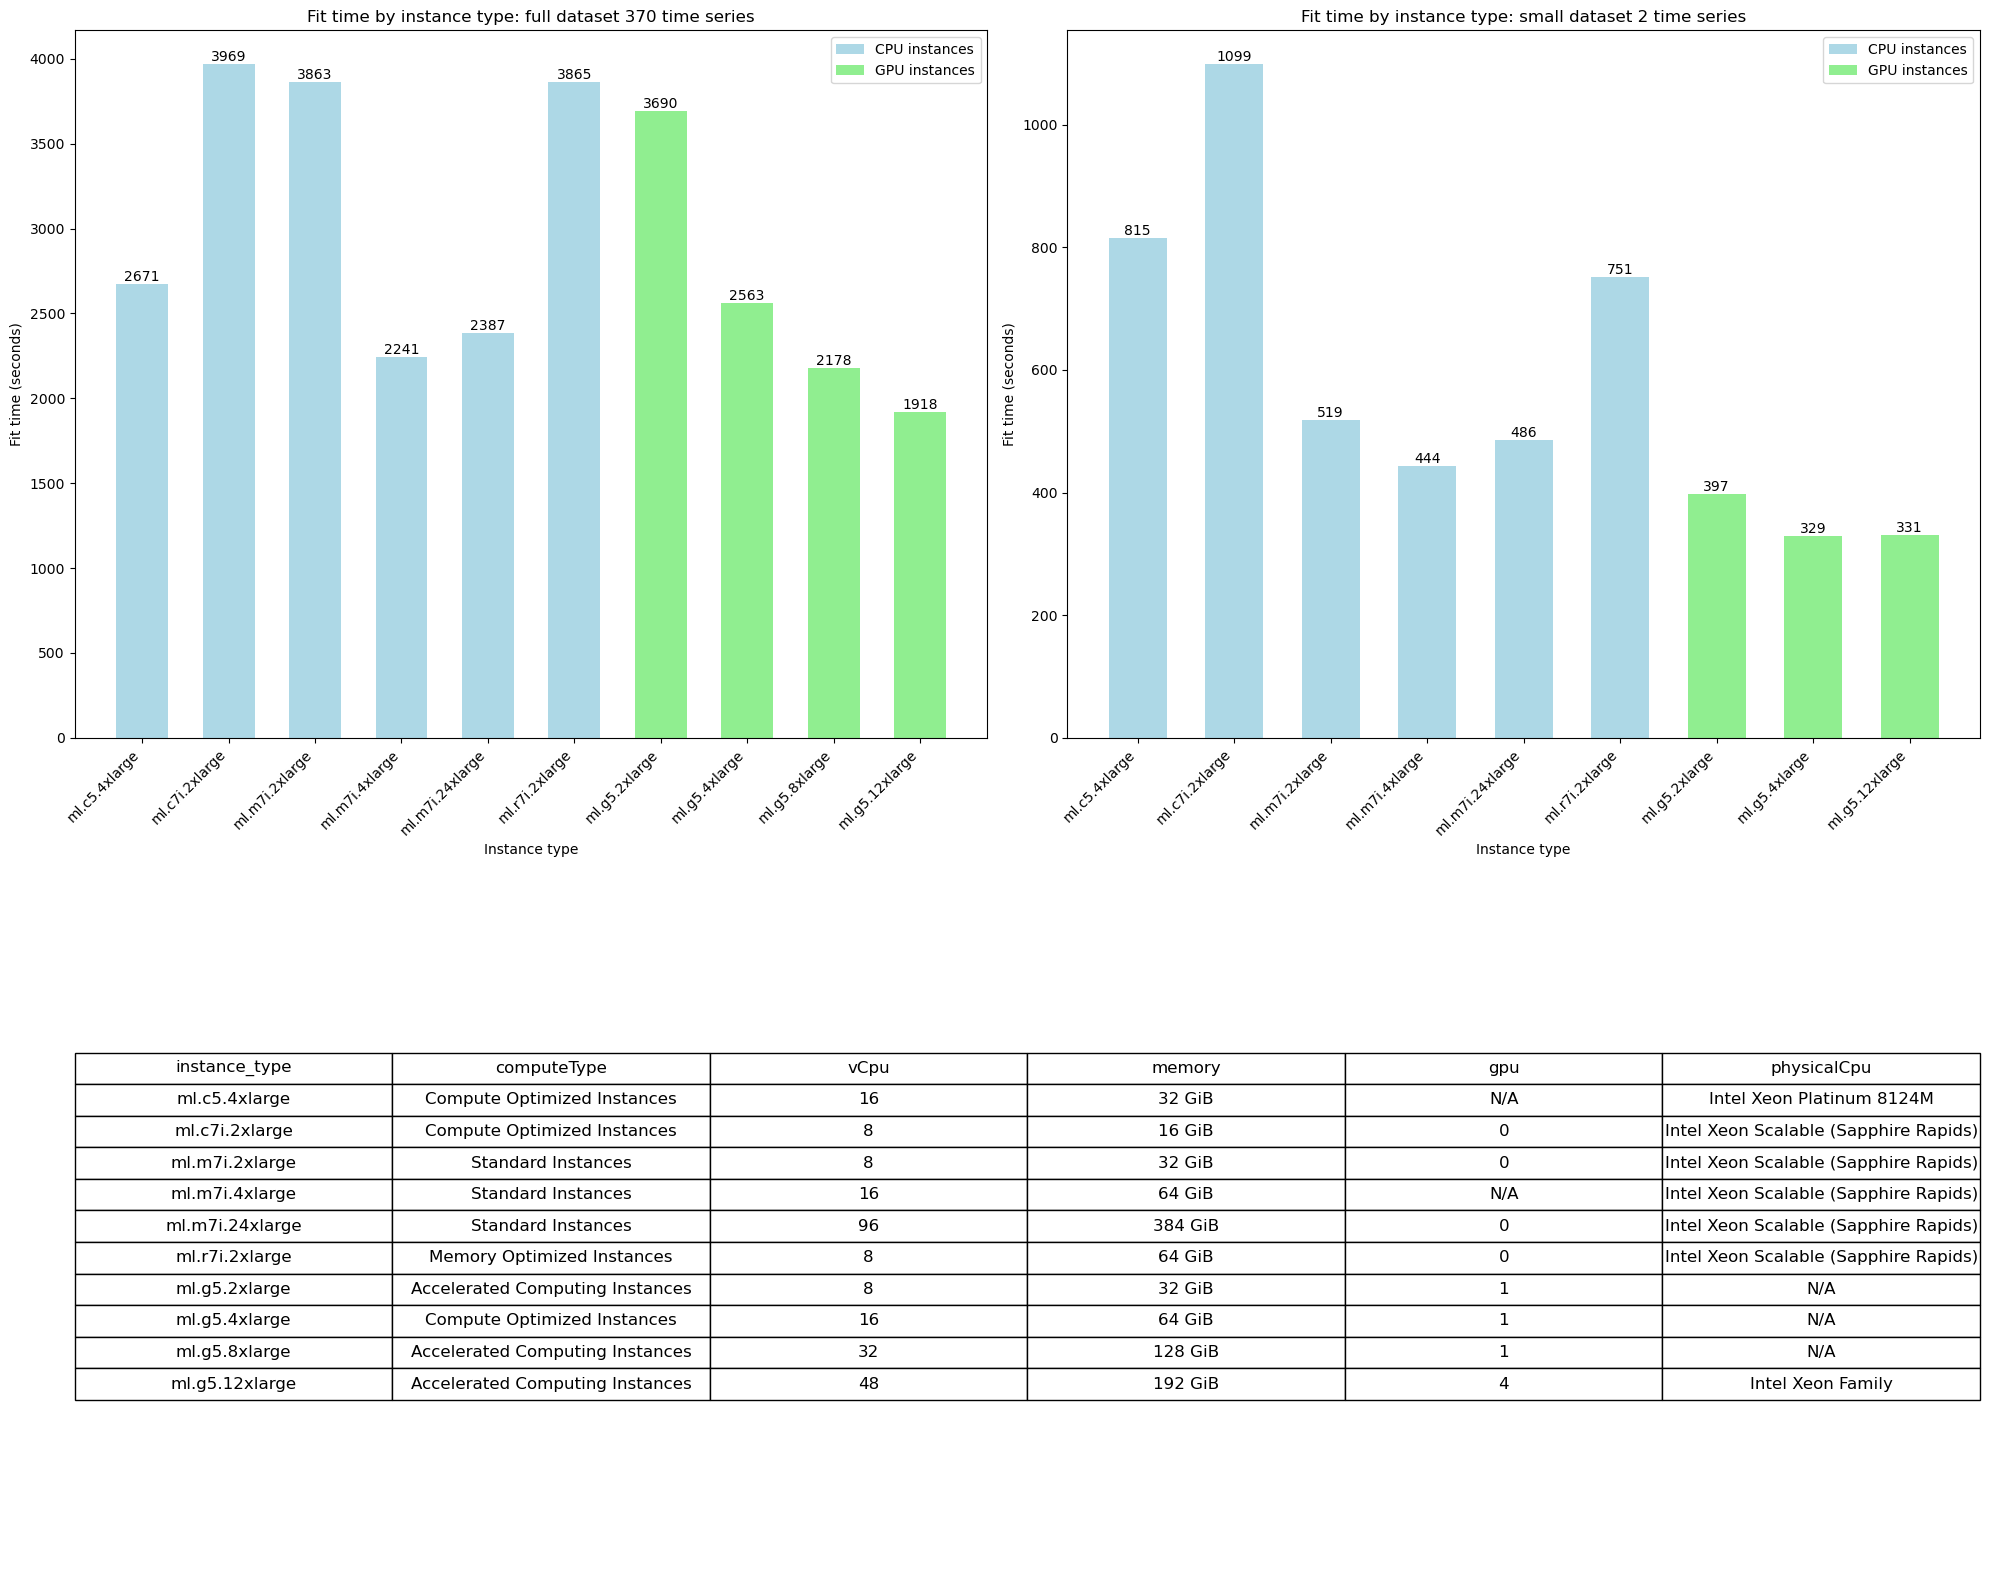

In [40]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create the subplots
ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, :])

create_bar_chart(ax1, data_cpu_full, data_gpu_full, f'Fit time by instance type: full dataset {data_kw.shape[1]} time series')
create_bar_chart(ax2, data_cpu_small, data_gpu_small, f'Fit time by instance type: small dataset {data_kw_small.shape[1]} time series')

ax3.axis('off')
table = ax3.table(cellText=instance_data_df.values, colLabels=instance_data_df.columns, loc='center', cellLoc='center')

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.show()

#### Fit
Run the model training by calling `TimeSeriesPredictor.fit()`:

In [41]:
# replace presets with "fast_training" for the lowest training time
presets = "high_quality" # "fast_training"

predictor.fit(
    train_data=train_df,
    # time_limit=30*60,
    presets=presets,
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon-2h-2-17533-20241003-120222'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Sep 10 22:02:55 UTC 2024
CPU Count:          16
GPU Count:          1
Memory Avail:       56.41 GB / 60.46 GB (93.3%)
Disk Space Avail:   92.24 GB / 99.95 GB (92.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2h'
Provided train_data has 34898 rows, 2 time series. Median time series length is 17449 (min=17449, max=17449). 


## Working with trained predictor

After training completed, you can access all information via `TimeSeriesPredictor` class.

In [42]:
# Detailed information about models trained
predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
                        model  score_val  pred_time_val  fit_time_marginal  \
0            WeightedEnsemble  -0.055955      11.050719           0.688445   
1               Chronos[base]  -0.059391      10.881259           0.020756   
2               DirectTabular  -0.059402       0.135300           7.524280   
3                      DeepAR  -0.061339       0.290228          85.097296   
4                   AutoARIMA  -0.065268      18.042335           0.025398   
5   TemporalFusionTransformer  -0.065789       0.034159         119.182343   
6                    PatchTST  -0.069272       0.022163          32.103333   
7                        NPTS  -0.080733       2.028989           0.026417   
8                     AutoETS  -0.082288      22.654503           0.025604   
9               SeasonalNaive  -0.083569       1.327837           0.030146   
10      DynamicOptimizedTheta  -0.104052      34.6

{'model_types': {'SeasonalNaive': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'CrostonSBA': 'MultiWindowBacktestingModel',
  'NPTS': 'MultiWindowBacktestingModel',
  'DynamicOptimizedTheta': 'MultiWindowBacktestingModel',
  'AutoETS': 'MultiWindowBacktestingModel',
  'AutoARIMA': 'MultiWindowBacktestingModel',
  'Chronos[base]': 'MultiWindowBacktestingModel',
  'TemporalFusionTransformer': 'MultiWindowBacktestingModel',
  'DeepAR': 'MultiWindowBacktestingModel',
  'PatchTST': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'SeasonalNaive': -0.08356897913493307,
  'RecursiveTabular': -0.12067453586929384,
  'DirectTabular': -0.05940155858028876,
  'CrostonSBA': -0.27868785419858527,
  'NPTS': -0.08073307874740308,
  'DynamicOptimizedTheta': -0.1040523933750404,
  'AutoETS': -0.08228833806863411,
  'AutoARIMA': -0.06526839432808555,
  'Chron

In [43]:
# Dictionary of model details
predictor.info()

{'path': 'autogluon-2h-2-17533-20241003-120222',
 'version': '1.1.1',
 'time_fit_training': 362.2934982776642,
 'time_limit': None,
 'best_model': 'WeightedEnsemble',
 'best_model_score_val': -0.05595539462018293,
 'num_models_trained': 13,
 'model_info': {'SeasonalNaive': {'name': 'SeasonalNaive',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': WQL,
   'fit_time': 0.030146121978759766,
   'predict_time': 1.3278372287750244,
   'freq': '2h',
   'prediction_length': 84,
   'quantile_levels': [0.1, 0.5, 0.9],
   'val_score': -0.08356897913493307,
   'hyperparameters': {},
   'info_per_val_window': [{'window_index': 0,
     'refit_this_window': True,
     'fit_time': 0.005670309066772461,
     'val_score': -0.08356897913493307,
     'predict_time': 1.3278372287750244}]},
  'RecursiveTabular': {'name': 'RecursiveTabular',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': WQL,
   'fit_time': 16.648781061172485,
   'predict_time': 1.6046223640441895,
   'fre

See the AutoGluon documentation on the [`leaderboard()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.leaderboard.html) method for description of each shown column.

In [44]:
# Model leaderboard with scoring
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.055955,11.050719,0.688445,13
1,Chronos[base],-0.059391,10.881259,0.020756,9
2,DirectTabular,-0.059402,0.135300,7.524280,3
3,DeepAR,-0.061339,0.290228,85.097296,11
4,AutoARIMA,-0.065268,18.042335,0.025398,8
5,TemporalFusionTransformer,-0.065789,0.034159,119.182343,10
6,PatchTST,-0.069272,0.022163,32.103333,12
7,NPTS,-0.080733,2.028989,0.026417,5
8,AutoETS,-0.082288,22.654503,0.025604,7
9,SeasonalNaive,-0.083569,1.327837,0.030146,1


In [45]:
# You can provide a dataset to evaluate the model leaderboard based on the test data
predictor.leaderboard(test_df)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DirectTabular,-0.096414,-0.059402,0.145470,0.135300,7.524280,3
1,WeightedEnsemble,-0.126380,-0.055955,2.264923,11.050719,0.688445,13
2,DeepAR,-0.148883,-0.061339,0.301172,0.290228,85.097296,11
3,PatchTST,-0.156022,-0.069272,0.037717,0.022163,32.103333,12
4,TemporalFusionTransformer,-0.159521,-0.065789,0.078531,0.034159,119.182343,10
5,Chronos[base],-0.167690,-0.059391,2.039164,10.881259,0.020756,9
6,NPTS,-0.167906,-0.080733,1.093779,2.028989,0.026417,5
7,AutoARIMA,-0.170228,-0.065268,19.383790,18.042335,0.025398,8
8,DynamicOptimizedTheta,-0.199741,-0.104052,33.270169,34.670147,0.025602,6
9,RecursiveTabular,-0.206484,-0.120675,0.826181,1.604622,16.648781,2


To load all saved predictor data including the model leaderboard, logs, and the trained model you use the [`load()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.load.html) method of the `TimeSeriesPredictor` class.

In [47]:
# list all autogluon data saved to the EBS volume
!ls -dt {experiment_prefix}*/

autogluon-2h-2-17533-20241003-120222/  autogluon-2h-370-17533-20240930-084718/
autogluon-2h-2-17533-20241002-084245/


In [48]:
# uncomment if you need to load a predictor from the saved data
# predictor_data_path="autogluon-2H-370-17533-20240905-214138"
# predictor = TimeSeriesPredictor.load(predictor_data_path)

### Model performance

To measure how accurately `TimeSeriesPredictor` can forecast unseen time series, you can use the method [`TimeSeriesPredictor.evaluate()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.evaluate.html). This method measures the model accuracy using the last `prediction_length` time steps of each time series in data as a hold-out set, in this case in the dataset `test_df`.

In [49]:
metrics = ['WQL', 'MAPE', 'WAPE', 'RMSE', 'MASE']
# You can also specify a model name via `model` parameter
model_metrics = predictor.evaluate(
    data=test_df, 
    metrics=metrics, 
    # model="DeepAR", 
    display=True)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Evaluations on test data:
{
    "WQL": -0.12637969418423586,
    "MAPE": -0.3472891296275516,
    "WAPE": -0.17652918022291744,
    "RMSE": -371.9282334638553,
    "MASE": -2.713621309569786
}


#### Save the model performance to a file

In [50]:
def display_and_save_metrics(
    model_metrics,
    experiment_name,
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime()),
    display_only=False,
):
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
    model_metrics_df['experiment'] = experiment_name
    model_metrics_df['timestamp'] = timestamp
    # AutoGluon flips the sign of a metric, multiply by -1
    model_metrics_df['value'] = model_metrics_df['value'] * (-1)
    model_metrics_df = model_metrics_df[['timestamp','metric_name','value','experiment']]

    print(model_metrics_df)

    if not display_only:
        model_metrics_df.to_csv(f'./model-performance/{experiment_name}-{timestamp}.csv', index=False)

    return model_metrics_df

In [51]:
os.makedirs("./model-performance", exist_ok=True)

In [52]:
display_and_save_metrics(model_metrics, experiment_name, timestamp)

         timestamp metric_name       value            experiment
0  20241003-120222         WQL    0.126380  autogluon-2h-2-17533
1  20241003-120222        MAPE    0.347289  autogluon-2h-2-17533
2  20241003-120222        WAPE    0.176529  autogluon-2h-2-17533
3  20241003-120222        RMSE  371.928233  autogluon-2h-2-17533
4  20241003-120222        MASE    2.713621  autogluon-2h-2-17533


,timestamp,metric_name,value,experiment
0,20241003-120222,WQL,0.126380,autogluon-2h-2-17533
1,20241003-120222,MAPE,0.347289,autogluon-2h-2-17533
2,20241003-120222,WAPE,0.176529,autogluon-2h-2-17533
3,20241003-120222,RMSE,371.928233,autogluon-2h-2-17533
4,20241003-120222,MASE,2.713621,autogluon-2h-2-17533


## Generate predictions and visualize

To generate predictions and to plot the results you use the methonds [`predict()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.predict.html) and [`plot()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.plot.html) of the `TimeSeriesPredictor`.

In [53]:
# persist models in memory for reduced inference latency
predictor.persist()

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['DirectTabular',
 'Chronos[base]',
 'WeightedEnsemble',
 'TemporalFusionTransformer']

In [73]:
prediction_df = predictor.predict(test_df.slice_by_timestep(end_index=-1))

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


`predict()` method generates `prediction_length` starting from the end of the provided time series:

In [75]:
prediction_df

mean          0.1          0.5  \
item_id timestamp                                                    
MT_330  2015-01-01 00:00:00    40.460136    37.075455    40.460138   
        2015-01-01 02:00:00    41.683487    36.826296    41.562067   
        2015-01-01 04:00:00    46.347342    40.024496    45.952724   
        2015-01-01 06:00:00    59.733961    49.172460    59.961626   
        2015-01-01 08:00:00    76.511931    56.657091    78.424312   
...                                  ...          ...          ...   
MT_357  2015-01-07 14:00:00  2479.106016  2264.156262  2499.612493   
        2015-01-07 16:00:00  2572.243194  2305.860563  2603.160761   
        2015-01-07 18:00:00  1966.464148  1780.607899  1982.554005   
        2015-01-07 20:00:00  1217.773604   928.542411  1215.565189   
        2015-01-07 22:00:00   964.362892   776.545459   960.261584   

                                     0.9  
item_id timestamp                         
MT_330  2015-01-01 00:00:00    49.656248  
        2015-01-01 02:00:00    50.503576  
        2015-01-01 04:00:00    54.531998  
        2015-01-01 06:00:00    80.254618  
        2015-01-01 08:00:00    98.270102  
...                                  ...  
MT_357  2015-01-07 14:00:00  2763.544932  
        2015-01-07 16:00:00  2836.472223  
        2015-01-07 18:00:00  2319.402632  
        2015-01-07 20:00:00  1554.436805  
        2015-01-07 22:00:00  1224.656384  

[168 rows x 4 columns]

`plot()` method plots predictions together with historical time series and confidence interval based on forecast quantiles.

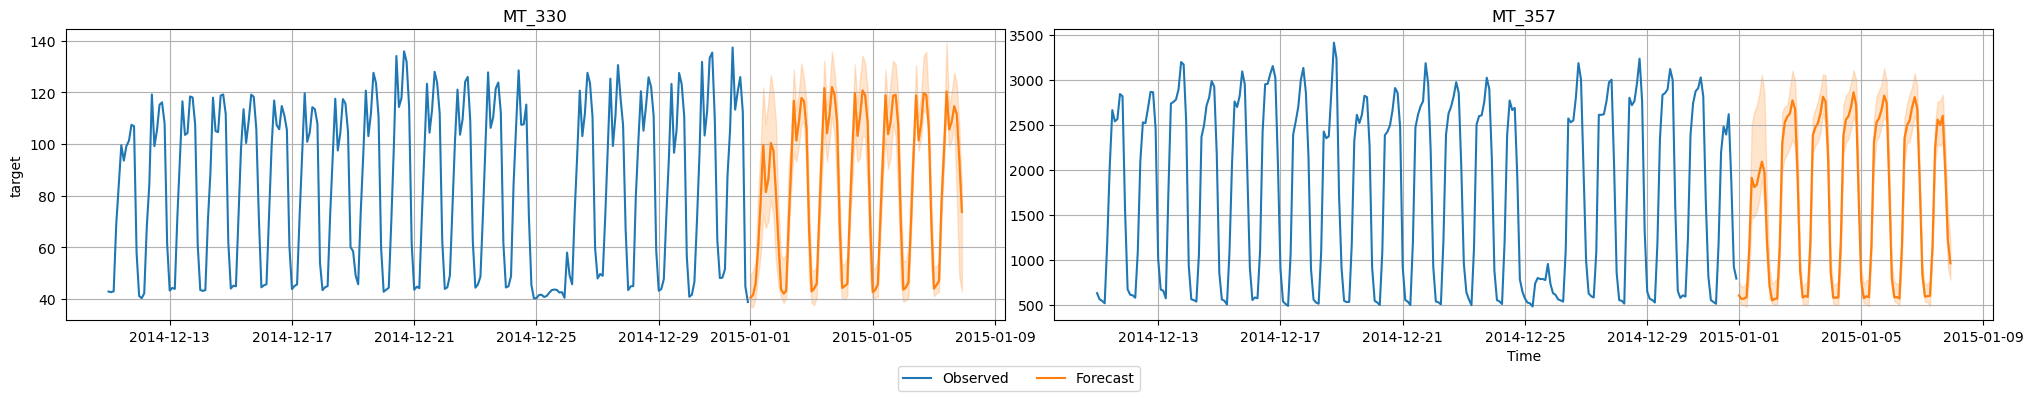

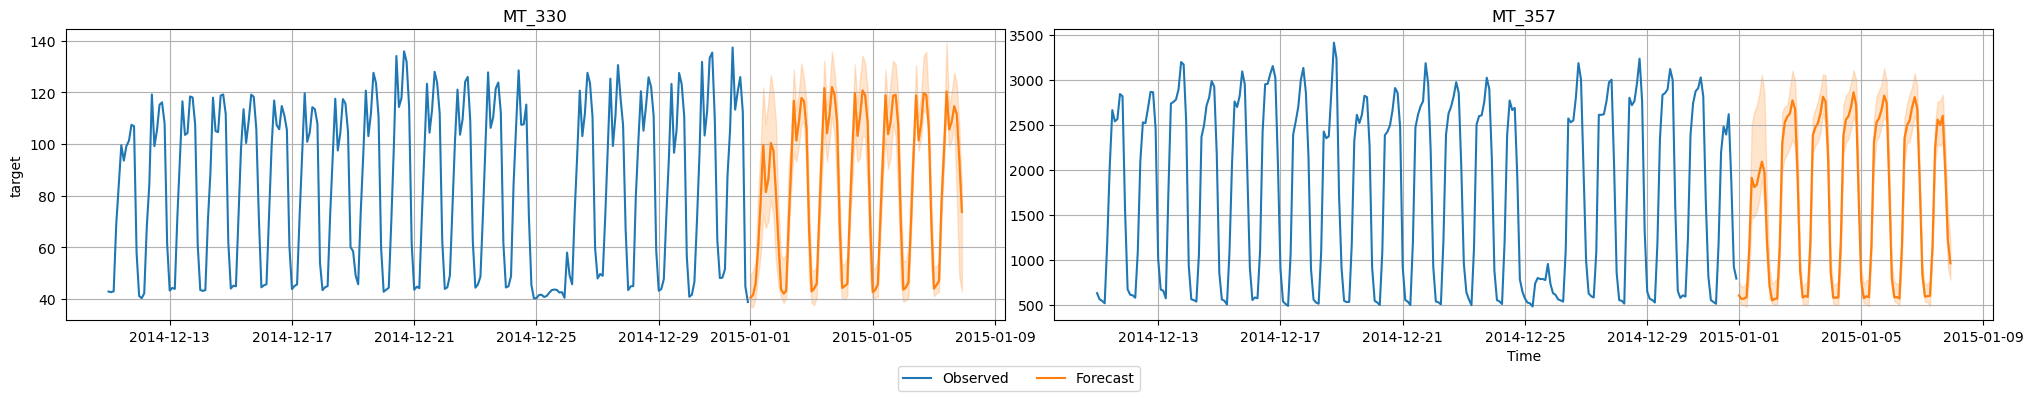

In [78]:
predictor.plot(
    data=test_df.slice_by_timestep(end_index=-1),
    predictions=prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=prediction_df.item_ids[0:2],
    max_history_length=prediction_length*3,   
)

Experiment with different trained models and prediction dates to generate forecast. You can change the following parameters:

- `Model`: select any model from the predictor's leaderboard
- `Time series ids`: id of the time series to forecast. You can select multiple time series to plot together
- `Offset days`: how many days back from the data end the prediction starts
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history series

In [57]:
style = {"description_width": "initial"}
ts_id_list = test_df.item_ids.to_list()

In [58]:
@interact_manual(
    model=Dropdown(options=predictor.leaderboard()['model'].to_list(), description='Model:'),
    ts_ids=SelectMultiple(options=ts_id_list,value=[ts_id_list[0]], rows=5, style=style, description='Time series ids:'),
    offset_days=IntSlider(min=-365, max=0, value=0, style=style, description='Offset days:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    continuous_update=False,
)
def plot_interact(
    model,
    ts_ids,
    offset_days,
    history_length,
):
    offset = -offset_days * intervals_per_day + 1
    data_end_index = offset - prediction_length + 1

    data_df = test_df.slice_by_timestep(end_index=-data_end_index) if offset > prediction_length else test_df
    inference_df = test_df.slice_by_timestep(end_index=-offset)
    prediction_df = predictor.predict(data=inference_df, model=model)
        
    predictor.plot(
        data=data_df,
        predictions=prediction_df,
        quantile_levels=forecast_quantiles,
        item_ids=list(ts_ids),
        max_history_length=history_length*prediction_length,   
    )

    plt.show()

interactive(children=(Dropdown(description='Model:', options=('WeightedEnsemble', 'Chronos[base]', 'DirectTabu…

---

## Use Chronos with AutoGluon

This section uses content from the AutoGluon documentation [Forecasting with Chronos](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html).

<div class="alert alert-info">If you run this notebook on a CPU-only instance, you can use Chronos models <code>tiny</code> and <code>mini</code> only.</div>

Chronos on AutoGluon is available in five model sizes with different [numbers of parameters](https://github.com/amazon-science/chronos-forecasting/tree/main?tab=readme-ov-file#architecture): `tiny` (8M), `mini` (20M), `small` (46M), `base` (200M), and `large` (710M). 

Being a pretrained transformer model for zero-shot forecasting, Chronos is different from other models available in AutoGluon Time Series. Chronos models do not really fit time series data during training time with `fit()`. When `predict()` is called, it carries out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, or generative AI foundation models where expensive computation happens during inference. Computation for `small`, `base`, and `large` Chronos models requires a GPU accelerator chip to run in a reasonable amount of time.

The easiest way to get started with Chronos is through model-specific presets available in the [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html). As of v1.1, the `fit()` method has five specific Chronos presets corresponding to each model size, such as `chronos_small` or `chronos_base` and two Chronos-specific ensemble presets.

In ensemble mode Chronos `base` or `large` models are combined with other time series models using presets `chronos_ensemble` and `chronos_large_ensemble`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

Note that the model sizes `small` and higher require a GPU to run.

### Create a predictor
Create a `TimeSeriesPredictor` for Chronos usage.

In [59]:
train_df.shape

(34898, 1)

In [60]:
chronos_predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=prediction_length,
    eval_metric=eval_metric,
    quantile_levels=forecast_quantiles,
)

### Fit Chronos models

In [61]:
number_of_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {number_of_gpus}")

if number_of_gpus < 1:
    chronos_size = 'mini'
elif number_of_gpus == 1:
    chronos_size = 'base'
else:
    chronos_size = 'large'

Number of GPUs available: 1


In [62]:
chronos_predictor.fit(
    train_data=train_df,
    presets=f"chronos_{chronos_size}",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241003_130044'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Sep 10 22:02:55 UTC 2024
CPU Count:          16
GPU Count:          1
Memory Avail:       52.82 GB / 60.46 GB (87.4%)
Disk Space Avail:   92.21 GB / 99.95 GB (92.3%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 84,
 'quantile_levels': [0.1, 0.5, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: '2h'
Provided train_data has 34898 rows, 2 time series. Median time series length is 17449 (m

In [63]:
chronos_predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,Chronos[base],None,None,0.000367,1


As you can see, Chronos does not take any time to `fit`. The `fit` still does some of tasks under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

### Generate predictions and visualize

Use the `predict()` method to generate forecasts, and the `plot()` method to visualize them.

In [64]:
test_df.shape

(35066, 1)

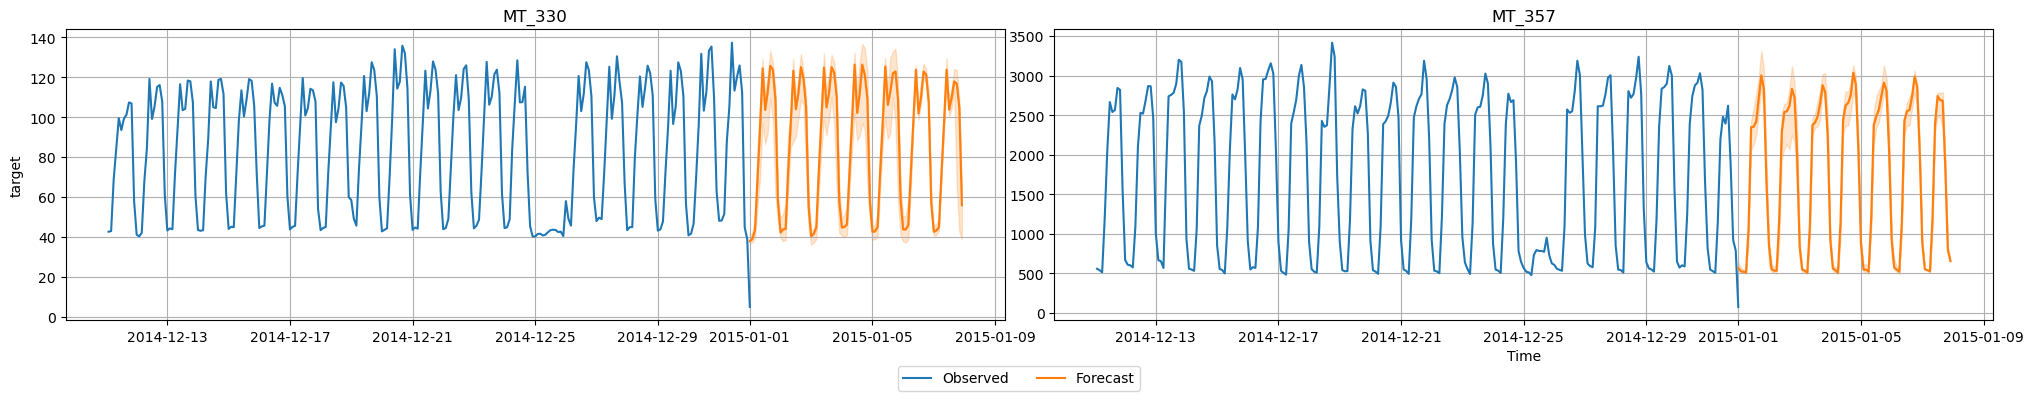

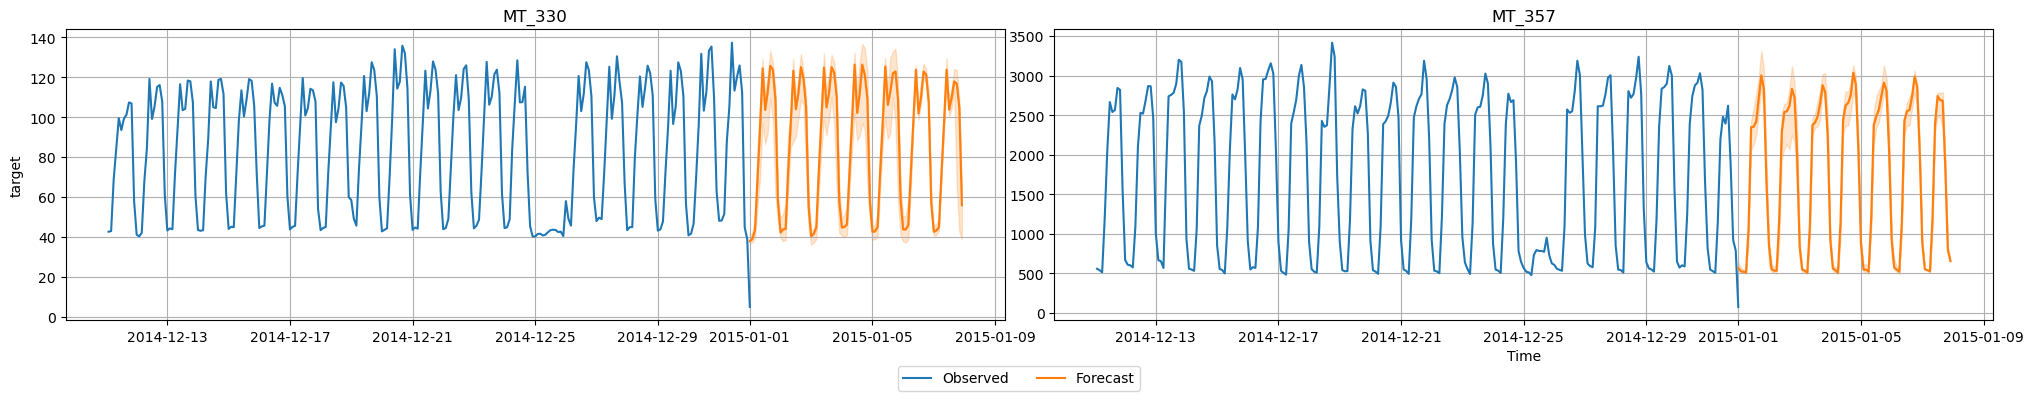

In [65]:
model = chronos_predictor.leaderboard()['model'][0]

# remove the last time step in the test dataset because of the artifact where the target goes to zero
chronos_prediction_df = chronos_predictor.predict(data=test_df.slice_by_timestep(end_index=-1), model=model)

chronos_predictor.plot(
    data=test_df,
    predictions=chronos_prediction_df,
    quantile_levels=forecast_quantiles,
    item_ids=chronos_prediction_df.item_ids[:2],
    max_history_length=prediction_length*3,   
)

### Chronos model performance

In [79]:
metrics = ['WQL', 'MAPE', 'WAPE', 'RMSE', 'MASE']
chronos_model_metrics = chronos_predictor.evaluate(
    data=test_df.slice_by_timestep(end_index=-1), 
    metrics=metrics, 
    model=model,
    display=True)

Evaluations on test data:
{
    "WQL": -0.16119010837896247,
    "MAPE": -0.29638194258471284,
    "WAPE": -0.20094618241109508,
    "RMSE": -433.85061182125287,
    "MASE": -3.1233914860948135
}


In [80]:
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())
chronos_experiment_name = f"{experiment_prefix}-{model}-{freq}-{ts_wide_df.shape[1]}-{ts_wide_df.shape[0]}"
chronos_predictor_data_path = f"{chronos_experiment_name}-{timestamp}"

print(f"Experiment name: {chronos_experiment_name}")

Experiment name: autogluon-Chronos[base]-2h-2-17533


In [81]:
display_and_save_metrics(chronos_model_metrics, chronos_experiment_name, timestamp)

         timestamp metric_name       value                          experiment
0  20241003-130326         WQL    0.161190  autogluon-Chronos[base]-2h-2-17533
1  20241003-130326        MAPE    0.296382  autogluon-Chronos[base]-2h-2-17533
2  20241003-130326        WAPE    0.200946  autogluon-Chronos[base]-2h-2-17533
3  20241003-130326        RMSE  433.850612  autogluon-Chronos[base]-2h-2-17533
4  20241003-130326        MASE    3.123391  autogluon-Chronos[base]-2h-2-17533


,timestamp,metric_name,value,experiment
0,20241003-130326,WQL,0.161190,autogluon-Chronos[base]-2h-2-17533
1,20241003-130326,MAPE,0.296382,autogluon-Chronos[base]-2h-2-17533
2,20241003-130326,WAPE,0.200946,autogluon-Chronos[base]-2h-2-17533
3,20241003-130326,RMSE,433.850612,autogluon-Chronos[base]-2h-2-17533
4,20241003-130326,MASE,3.123391,autogluon-Chronos[base]-2h-2-17533


#### Backtesting using multiple windows
You can more accurately estimate the performance using backtest with multiple windows by evaluating performance on multiple forecast horizons generated from the same time series.
The AutoGluon class `ExpandingWindowSplitter` provides the needed functionality to split the dataset.

Multi-window backtesting can result in more accurate estimation of the forecast quality on **unseen** data.

Window 0: score = {'WQL': -0.06209787753477953, 'MAPE': -0.06746064922477861, 'WAPE': -0.08421823660867973, 'RMSE': -156.7660674499587, 'MASE': -1.0645723619181064}
Window 1: score = {'WQL': -0.07487731886035165, 'MAPE': -0.0732959872117588, 'WAPE': -0.10127636576307167, 'RMSE': -193.1477008071596, 'MASE': -1.293789803653484}
Window 2: score = {'WQL': -0.05959114184043921, 'MAPE': -0.09920309357878669, 'WAPE': -0.0771339021479525, 'RMSE': -231.25381115608064, 'MASE': -1.311839431999609}
Window 3: score = {'WQL': -0.16119010837896247, 'MAPE': -0.29638194258471284, 'WAPE': -0.20094618241109508, 'RMSE': -433.85061182125287, 'MASE': -3.1233914860948135}


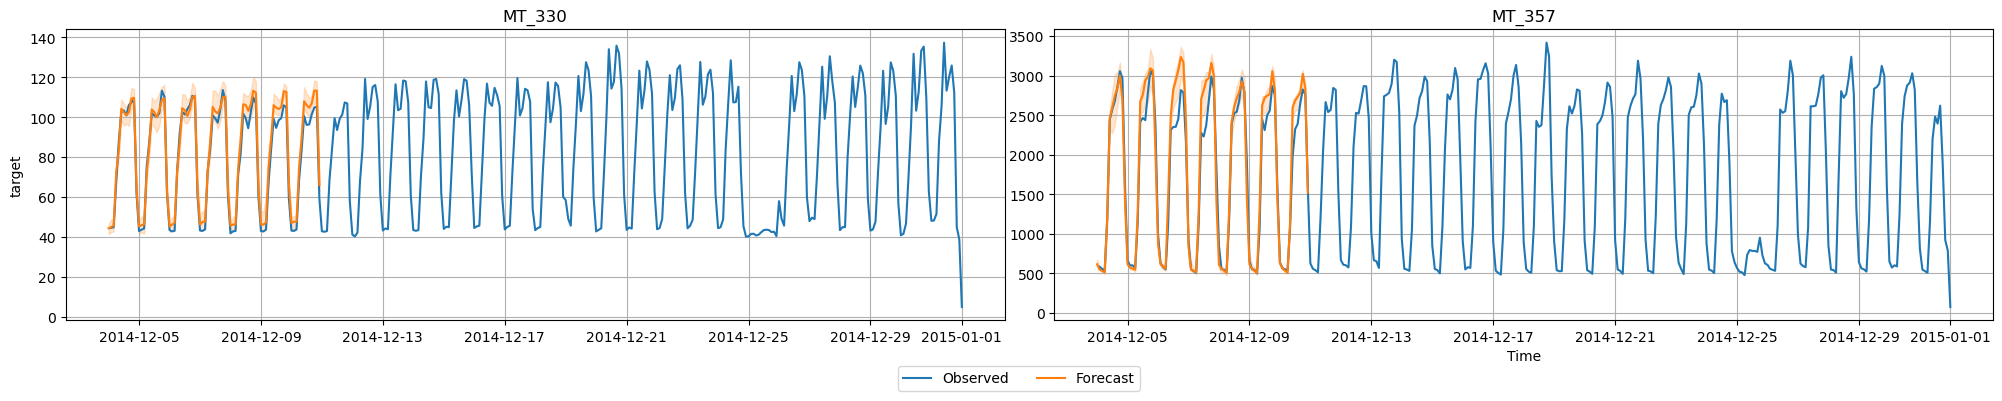

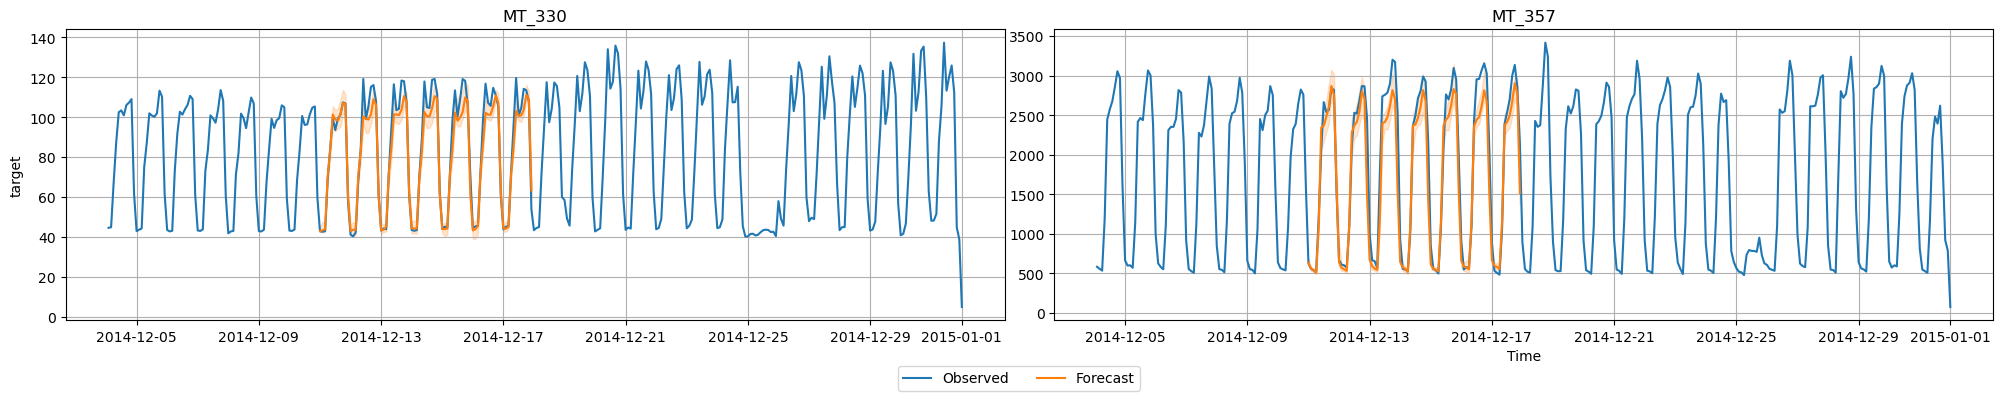

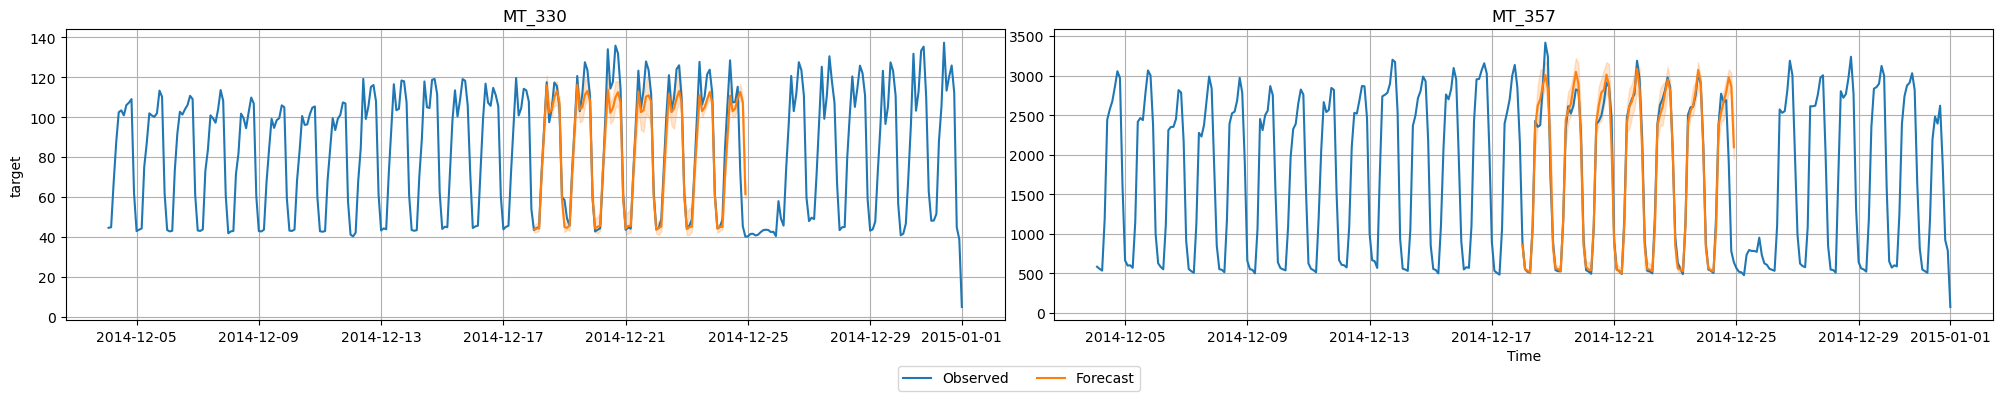

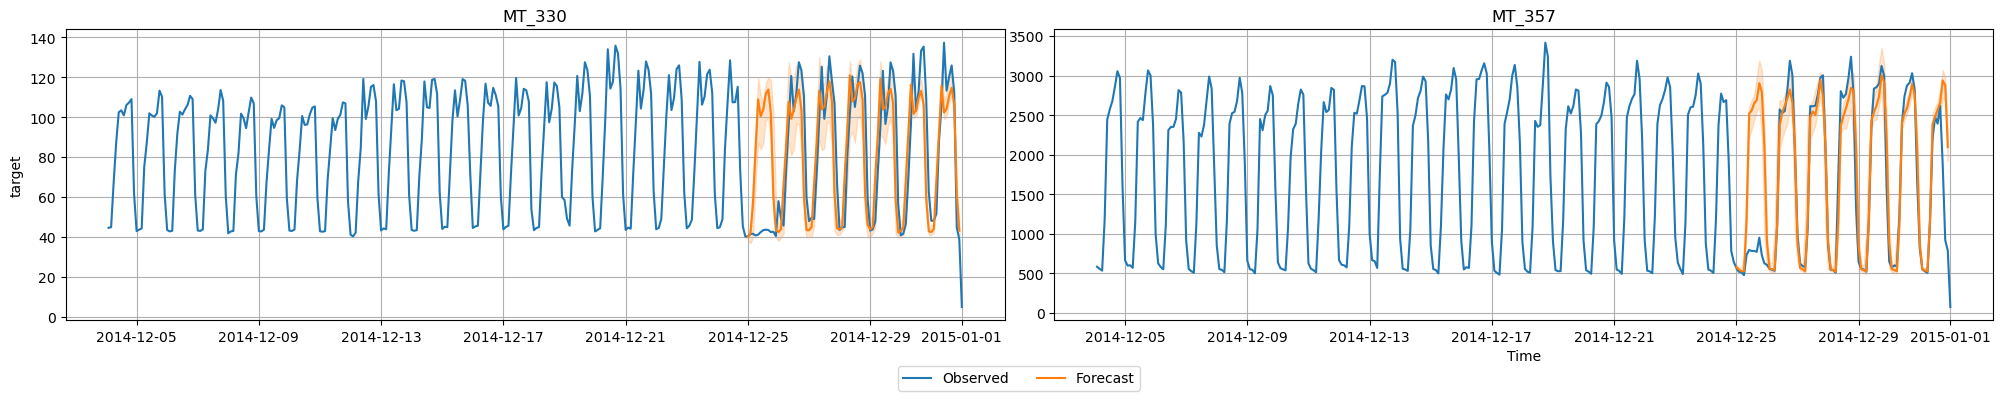

In [82]:
n_windows = 4
splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=n_windows)
item_ids = test_df.item_ids[:2]
scores = []

for window_idx, (train_split, val_split) in enumerate(splitter.split(test_df.slice_by_timestep(end_index=-1))):
    # predict
    split_prediction_df = chronos_predictor.predict(data=val_split.slice_by_timestep(end_index=-prediction_length), model=model)
    # visualize
    chronos_predictor.plot(
        data=test_df.slice_by_timestep(start_index=-n_windows*prediction_length),
        predictions=split_prediction_df,
        item_ids=item_ids,
    )
    # evaluate
    score = chronos_predictor.evaluate(
        data=val_split,
        metrics=metrics,
        model=model,
    )
    
    print(f"Window {window_idx}: score = {score}")
    scores.append(score)

#### Save the model performance to a file
Save the scoring from the backtest with multiple windows to a file. The simplest method to calculate an aggregated metric for backtest with multiple windows is to take the arithmetic mean across all windows. This gives equal weight to each window. You can also use the median metric value across windows that can be more robust to outliers.

In [83]:
display_and_save_metrics(
    model_metrics=pd.DataFrame(data=scores).mean().to_dict(), 
    experiment_name=f"{chronos_experiment_name}-bt{n_windows}", 
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime())
)

         timestamp metric_name       value  \
0  20241003-130334         WQL    0.089439   
1  20241003-130334        MAPE    0.134085   
2  20241003-130334        WAPE    0.115894   
3  20241003-130334        RMSE  253.754548   
4  20241003-130334        MASE    1.698398   

                               experiment  
0  autogluon-Chronos[base]-2h-2-17533-bt4  
1  autogluon-Chronos[base]-2h-2-17533-bt4  
2  autogluon-Chronos[base]-2h-2-17533-bt4  
3  autogluon-Chronos[base]-2h-2-17533-bt4  
4  autogluon-Chronos[base]-2h-2-17533-bt4  


,timestamp,metric_name,value,experiment
0,20241003-130334,WQL,0.089439,autogluon-Chronos[base]-2h-2-17533-bt4
1,20241003-130334,MAPE,0.134085,autogluon-Chronos[base]-2h-2-17533-bt4
2,20241003-130334,WAPE,0.115894,autogluon-Chronos[base]-2h-2-17533-bt4
3,20241003-130334,RMSE,253.754548,autogluon-Chronos[base]-2h-2-17533-bt4
4,20241003-130334,MASE,1.698398,autogluon-Chronos[base]-2h-2-17533-bt4


### Optional: configuring for performance

As with all large deep learning models some fine-grained control of inference parameters can be needed to both optimize the speed and avoid out-of-memory issues on specific hardware. For this, we will need to dive a bit deeper, configuring `hyperparameters` of the `TimeSeriesPredictor` directly.

In [74]:
chronos_cpu_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df,
    hyperparameters={
        "Chronos": {
            "model_path": "mini",
            "batch_size": 64,
            "device": "cpu"
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [69]:
%%time
predictions = chronos_cpu_predictor.predict(test_df)

CPU times: user 38.1 s, sys: 13.8 s, total: 51.9 s
Wall time: 7.03 s


You used the following configuration options for the `TimeSeriesPredictor`:
- `skip_model_selection=True` to skip running backtests during `fit`, as you use a single model only.
- in the `hyperparameters` for the Chronos model,
    - `model_path` allows to change the model size or select different pretrained weights. This parameter can be a model string like `tiny` or `base`, a Hugging Face path like `amazon/chronos-t5-mini`, or a path to a local folder with custom weights.
    - `batch_size` configures the number of time series for which predictions are generated in parallel.
    - `device` instructs Chronos to run the model on CPU.

If you run this notebook on a GPU-instances, you see that inference speed is slower on the CPU. To improve inference speed AutoGluon implementation of Chronos supports several deep learning compilers that can optimize model performance on CPUs.

For example, you can set `optimization_strategy="openvino"` to use the [OpenVINO](https://github.com/openvinotoolkit/openvino) compiler for Intel CPUs to speed up Chronos inference. Behind the scenes, AutoGluon will use Hugging Face [optimum](https://github.com/huggingface/optimum-intel) for this conversion.

Note that this requires installing the optional OpenVINO dependency for AutoGluon Time Series.

In [70]:
!pip install -q "autogluon.timeseries[chronos-openvino]"

To speed up the inference even further, we can `persist` the model after calling `fit`. The `TimeSeriesPredictor.persist()` method tells AutoGluon to keep the Chronos model in device memory for fast, on-demand inference instead of loading the model from disk each time.

In [71]:
%%capture
fast_chronos_cpu_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)
fast_chronos_cpu_predictor.persist()

In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode


In [72]:
%%time
predictions = fast_chronos_cpu_predictor.predict(test_df)

CPU times: user 13.2 s, sys: 1.08 s, total: 14.3 s
Wall time: 1.92 s


Depending on your environment and the used JupyterLab App instance you might see an increase in inference time.

You can also use the ONNX runtime by providing `optimization_strategy="onnx"`. For a discussion of these and other hyperparameters of Chronos, see the Chronos model [documentation](forecasting-model-zoo.md).

### Further Chronos experiments

You can use another Chronos-specific presets as described in the [`TimeSeriesPredictor.fit()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html) documentation:
- `chronos_ensemble`: builds an ensemble of seasonal naive, tree-based and deep learning models with fast inference and `chronos_small`.    
- `chronos_large_ensemble`: builds an ensemble of seasonal naive, tree-based and deep learning models with fast inference and `chronos_large`.

Feel free to experiment with these presets using code from this notebook.

<div class="alert alert-info">Note you can use these presets to fit models and run inference on GPU instances only.</div>

---

## AutoGluon Cloud

[AutoGluon Cloud](https://auto.gluon.ai/0.8.1/tutorials/cloud_fit_deploy/autogluon-cloud.html) is a framework designed to simplify the process of training, fine-tuning, and deploying AutoGluon-backed models on AWS. It aims to provide users with a straightforward way to manage MLOps without delving into the complexities of resource management. With AutoGluon Cloud, you can train models and perform inference on the cloud using just a few lines of code.

Currently, AutoGluon Cloud supports SageMaker as its cloud backend, allowing users to leverage SageMaker's capabilities for training and deploying models. The `autogluon.cloud` module provides APIs to use SageMaker containers for training and deploying AutoGluon-backed models. This includes support for tabular, multimodal, text, and image predictors. You can install [`autogluon.cloud`]((https://pypi.org/project/autogluon.cloud/)) via `pip` and then use it to train and deploy models, with compute managed by SageMaker and storage handled by Amazon S3.

For time series forecasting AutoGluon Cloud offers the [`TimeSeriesCloudPredictor`](https://auto.gluon.ai/cloud/dev/api/autogluon.cloud.TimeSeriesCloudPredictor.html). With `TimeSeriesCloudPredictor` you can train model remotely on SageMaker-managed compute using SageMaker training jobs.

Using AutoGluon Cloud can further simplify and scale development of time series forecast models.

---

## Clean up

In [93]:
# free memory
predictor.unpersist()

['TemporalFusionTransformer',
 'WeightedEnsemble',
 'AutoARIMA',
 'PatchTST',
 'DirectTabular']

## Shutdown kernel

In [253]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>